# Classifiers - low vs high difficulty - with TFv1
Exploring different classifiers with with the contractive autoencoder. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# required for the contractive autoencoder
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution()
import tensorflow.keras.backend as K
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
def scale_data(x, standardScaler=True, minMaxScaler=True):
    
    if standardScaler:
        # Scale with standard scaler
        sscaler = StandardScaler()
        sscaler.fit(x)
        x = sscaler.transform(x)

    if minMaxScaler:
        # Scale with MinMax to range [0,1]
        mmscaler = MinMaxScaler((0,1))
        mmscaler.fit(x)
        x = mmscaler.transform(x)
    
    return x

In [9]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [10]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [11]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [12]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
phase_all_train = scale_data(phase_all_train)

# load all phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
phase_all_valid = scale_data(phase_all_valid)

In [13]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [14]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [15]:
# AE Training params
batch_size = 256
epochs = 500
encoding_dim = 60
ae_encoded_shape = np.empty((0,encoding_dim))

In [16]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [17]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [18]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='sigmoid', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='linear', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [19]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

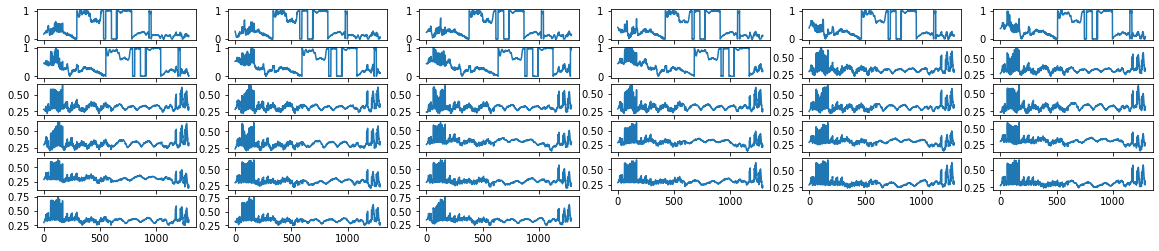

<Figure size 432x288 with 0 Axes>

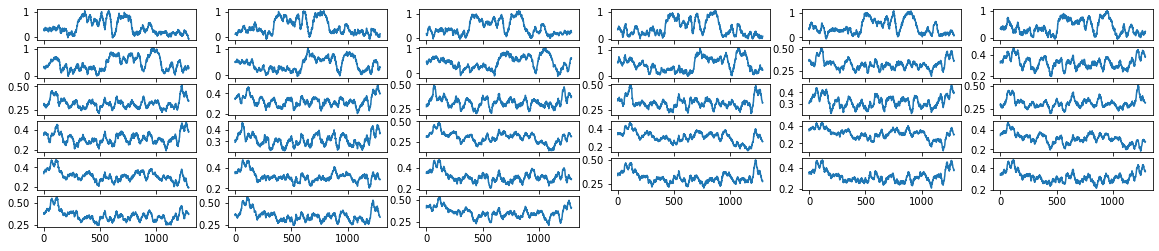

In [20]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

<Figure size 432x288 with 0 Axes>

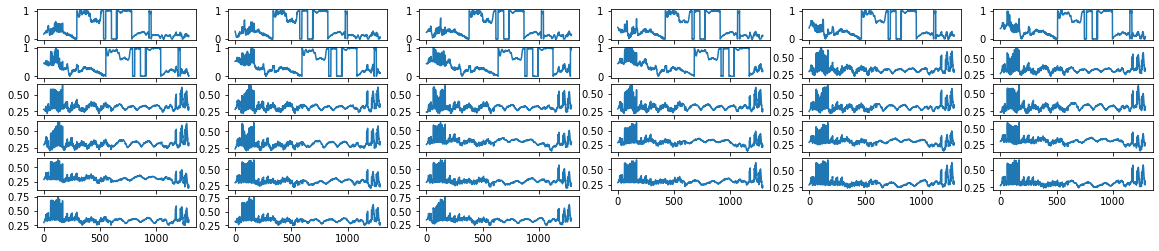

<Figure size 432x288 with 0 Axes>

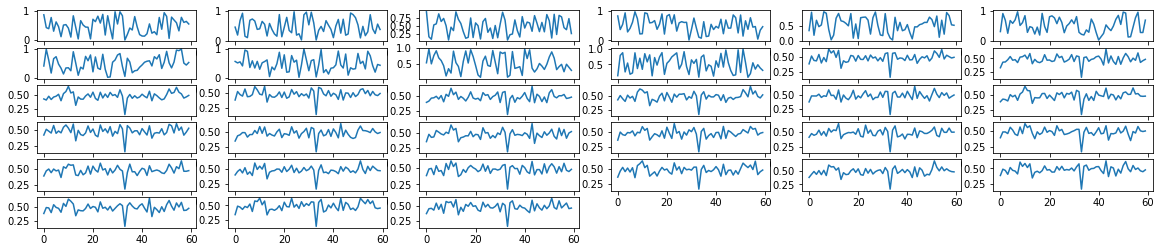

In [21]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

In [22]:
np.sum(np.mean(data2, axis=0) < 0.1)

0

Store the encoded representations in the data dictionary:

In [23]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [24]:
def get_ident_data_from_dict(idents, data_dict, should_scale_data=True):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    if should_scale_data:
        # Scale each data before returning
        phase = scale_data(phase)
        contractive_encoded = scale_data(contractive_encoded)
    
    return y, phase, contractive_encoded

In [25]:
# '62i9y''2gu87''iz2ps'

y_train, phase_train, contractive_encoded_train = get_ident_data_from_dict(['62i9y','2gu87'], data_dict)

phase_train2, y_train2, _, _, _ = get_data_from_idents_br_hb(path, ['62i9y','2gu87'], seconds)

phase_train2 = scale_data(phase_train2)

(phase_train == phase_train2).all()

True

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [26]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict, should_scale_data)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict, should_scale_data)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict, should_scale_data)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):

                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    set_random_seeds()
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [27]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'binary_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [28]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [29]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.007835
iteration: 2 of 23 ; time elapsed: 0:00:13.920501
iteration: 3 of 23 ; time elapsed: 0:00:27.785935
iteration: 4 of 23 ; time elapsed: 0:00:41.785544
iteration: 5 of 23 ; time elapsed: 0:00:55.960128
iteration: 6 of 23 ; time elapsed: 0:01:10.289930
iteration: 7 of 23 ; time elapsed: 0:01:25.174780
iteration: 8 of 23 ; time elapsed: 0:01:39.532054
iteration: 9 of 23 ; time elapsed: 0:01:54.086011
iteration: 10 of 23 ; time elapsed: 0:02:09.120022
iteration: 11 of 23 ; time elapsed: 0:02:24.352155
iteration: 12 of 23 ; time elapsed: 0:02:39.638863
iteration: 13 of 23 ; time elapsed: 0:02:55.128650
iteration: 14 of 23 ; time elapsed: 0:03:10.926438
iteration: 15 of 23 ; time elapsed: 0:03:26.922587
iteration: 16 of 23 ; time elapsed: 0:03:43.354759
iteration: 17 of 23 ; time elapsed: 0:03:59.543526
iteration: 18 of 23 ; time elapsed: 0:04:15.880012
iteration: 19 of 23 ; time elapsed: 0:04:32.322591
iteration: 20 of 23 ; time elapsed: 0:04

In [30]:
accuracies['simple_dense'] = accs

In [31]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.325000,0.491667,62i9y
1,0.466667,0.558333,2gu87
2,0.500000,0.450000,iz2ps
3,0.441667,0.533333,1mpau
4,0.483333,0.525000,7dwjy
5,0.416667,0.458333,7swyk
6,0.583333,0.733333,94mnx
7,0.508333,0.408333,bd47a
8,0.558333,0.558333,c24ur
9,0.483333,0.383333,ctsax


In [32]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.325000     0.383333
max     0.608333     0.733333
mean    0.490942     0.535870
median  0.483333     0.533333


#### LSTM-based classifier  
based on the original author's code

In [33]:
params_phase = {
    'kernel_size': 4,
    'filters': 3,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [34]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 2,
    'strides': 1,
    'pool_size': 1,
    'dropout': 0.09,
    'lstm_output_size': 4,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [35]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))
    model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [36]:
accs = helper_loop(LSTM_train, idents, n=5)

iteration: 1 of 5 ; time elapsed: 0:00:00.006881
iteration: 2 of 5 ; time elapsed: 0:17:31.656979
iteration: 3 of 5 ; time elapsed: 0:36:09.832872
iteration: 4 of 5 ; time elapsed: 0:55:42.896290
iteration: 5 of 5 ; time elapsed: 1:15:33.912536
Completed! Time elapsed: 1:36:02.393495


In [37]:
accuracies['LSTM'] = accs

In [38]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.566667,0.516667,62i9y
1,0.591667,0.500000,2gu87
2,0.541667,0.650000,iz2ps
3,0.400000,0.400000,1mpau
4,0.441667,0.500000,7dwjy


In [39]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.400000     0.400000
max     0.591667     0.650000
mean    0.508333     0.513333
median  0.541667     0.500000


#### kNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [41]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = KNN_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [42]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.009213
iteration: 2 of 23 ; time elapsed: 0:00:00.260587
iteration: 3 of 23 ; time elapsed: 0:00:00.534991
iteration: 4 of 23 ; time elapsed: 0:00:00.778341
iteration: 5 of 23 ; time elapsed: 0:00:01.026676
iteration: 6 of 23 ; time elapsed: 0:00:01.285983
iteration: 7 of 23 ; time elapsed: 0:00:01.576833
iteration: 8 of 23 ; time elapsed: 0:00:01.820659
iteration: 9 of 23 ; time elapsed: 0:00:02.064057
iteration: 10 of 23 ; time elapsed: 0:00:02.328462
iteration: 11 of 23 ; time elapsed: 0:00:02.594708
iteration: 12 of 23 ; time elapsed: 0:00:02.847999
iteration: 13 of 23 ; time elapsed: 0:00:03.089952
iteration: 14 of 23 ; time elapsed: 0:00:03.345799
iteration: 15 of 23 ; time elapsed: 0:00:03.661533
iteration: 16 of 23 ; time elapsed: 0:00:03.927972
iteration: 17 of 23 ; time elapsed: 0:00:04.182292
iteration: 18 of 23 ; time elapsed: 0:00:04.467529
iteration: 19 of 23 ; time elapsed: 0:00:04.727625
iteration: 20 of 23 ; time elapsed: 0:00

In [43]:
accuracies['kNN'] = accs

In [44]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.458333,0.466667,62i9y
1,0.658333,0.425000,2gu87
2,0.575000,0.641667,iz2ps
3,0.541667,0.625000,1mpau
4,0.558333,0.600000,7dwjy
5,0.391667,0.625000,7swyk
6,0.700000,0.600000,94mnx
7,0.475000,0.441667,bd47a
8,0.425000,0.533333,c24ur
9,0.566667,0.433333,ctsax


In [45]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.383333     0.425000
max     0.700000     0.641667
mean    0.512319     0.534783
median  0.508333     0.541667


####  SVC

In [46]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [47]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = SVC_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [48]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.006981
iteration: 2 of 23 ; time elapsed: 0:00:09.560566
iteration: 3 of 23 ; time elapsed: 0:00:18.967062
iteration: 4 of 23 ; time elapsed: 0:00:28.475253
iteration: 5 of 23 ; time elapsed: 0:00:38.038663
iteration: 6 of 23 ; time elapsed: 0:00:47.546695
iteration: 7 of 23 ; time elapsed: 0:00:57.141389
iteration: 8 of 23 ; time elapsed: 0:01:06.610629
iteration: 9 of 23 ; time elapsed: 0:01:16.000763
iteration: 10 of 23 ; time elapsed: 0:01:25.449490
iteration: 11 of 23 ; time elapsed: 0:01:34.863023
iteration: 12 of 23 ; time elapsed: 0:01:44.341845
iteration: 13 of 23 ; time elapsed: 0:01:53.894462
iteration: 14 of 23 ; time elapsed: 0:02:03.491088
iteration: 15 of 23 ; time elapsed: 0:02:12.972574
iteration: 16 of 23 ; time elapsed: 0:02:22.400397
iteration: 17 of 23 ; time elapsed: 0:02:31.926910
iteration: 18 of 23 ; time elapsed: 0:02:41.546154
iteration: 19 of 23 ; time elapsed: 0:02:51.051100
iteration: 20 of 23 ; time elapsed: 0:03

In [49]:
accuracies['SVC'] = accs

In [50]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.300000,0.450000,62i9y
1,0.433333,0.525000,2gu87
2,0.533333,0.466667,iz2ps
3,0.616667,0.541667,1mpau
4,0.475000,0.425000,7dwjy
5,0.558333,0.433333,7swyk
6,0.575000,0.700000,94mnx
7,0.500000,0.533333,bd47a
8,0.175000,0.491667,c24ur
9,0.533333,0.425000,ctsax


In [51]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.175000     0.425000
max     0.658333     0.816667
mean    0.500725     0.543478
median  0.525000     0.525000


#### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [53]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = random_forest_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [54]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.005984
iteration: 2 of 23 ; time elapsed: 0:00:12.283710
iteration: 3 of 23 ; time elapsed: 0:00:24.561744
iteration: 4 of 23 ; time elapsed: 0:00:36.983435
iteration: 5 of 23 ; time elapsed: 0:00:49.226677
iteration: 6 of 23 ; time elapsed: 0:01:00.870663
iteration: 7 of 23 ; time elapsed: 0:01:13.629406
iteration: 8 of 23 ; time elapsed: 0:01:29.002026
iteration: 9 of 23 ; time elapsed: 0:01:43.821074
iteration: 10 of 23 ; time elapsed: 0:01:57.330859
iteration: 11 of 23 ; time elapsed: 0:02:10.180615
iteration: 12 of 23 ; time elapsed: 0:02:23.202194
iteration: 13 of 23 ; time elapsed: 0:02:37.220049
iteration: 14 of 23 ; time elapsed: 0:02:50.831335
iteration: 15 of 23 ; time elapsed: 0:03:03.342856
iteration: 16 of 23 ; time elapsed: 0:03:15.550732
iteration: 17 of 23 ; time elapsed: 0:03:27.392319
iteration: 18 of 23 ; time elapsed: 0:03:39.468338
iteration: 19 of 23 ; time elapsed: 0:03:51.558717
iteration: 20 of 23 ; time elapsed: 0:04

In [55]:
accuracies['random_forest'] = accs

In [56]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.391667,0.441667,62i9y
1,0.400000,0.375000,2gu87
2,0.383333,0.500000,iz2ps
3,0.650000,0.600000,1mpau
4,0.333333,0.466667,7dwjy
5,0.375000,0.500000,7swyk
6,0.508333,0.616667,94mnx
7,0.475000,0.491667,bd47a
8,0.391667,0.508333,c24ur
9,0.466667,0.358333,ctsax


In [57]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.258333     0.358333
max     0.650000     0.683333
mean    0.469565     0.540580
median  0.466667     0.550000


#### Naive Bayesian

In [58]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [59]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [60]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.005856
iteration: 2 of 23 ; time elapsed: 0:00:00.205268
iteration: 3 of 23 ; time elapsed: 0:00:00.411744
iteration: 4 of 23 ; time elapsed: 0:00:00.631128
iteration: 5 of 23 ; time elapsed: 0:00:00.833615
iteration: 6 of 23 ; time elapsed: 0:00:01.033757
iteration: 7 of 23 ; time elapsed: 0:00:01.235246
iteration: 8 of 23 ; time elapsed: 0:00:01.441731
iteration: 9 of 23 ; time elapsed: 0:00:01.677848
iteration: 10 of 23 ; time elapsed: 0:00:01.877833
iteration: 11 of 23 ; time elapsed: 0:00:02.074307
iteration: 12 of 23 ; time elapsed: 0:00:02.267790
iteration: 13 of 23 ; time elapsed: 0:00:02.488228
iteration: 14 of 23 ; time elapsed: 0:00:02.716620
iteration: 15 of 23 ; time elapsed: 0:00:02.914687
iteration: 16 of 23 ; time elapsed: 0:00:03.111195
iteration: 17 of 23 ; time elapsed: 0:00:03.308245
iteration: 18 of 23 ; time elapsed: 0:00:03.524262
iteration: 19 of 23 ; time elapsed: 0:00:03.747664
iteration: 20 of 23 ; time elapsed: 0:00

In [61]:
accuracies['naive_bayesian'] = accs

In [62]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.475000,0.508333,62i9y
1,0.600000,0.508333,2gu87
2,0.516667,0.550000,iz2ps
3,0.641667,0.400000,1mpau
4,0.566667,0.483333,7dwjy
5,0.525000,0.433333,7swyk
6,0.725000,0.616667,94mnx
7,0.475000,0.366667,bd47a
8,0.475000,0.525000,c24ur
9,0.550000,0.291667,ctsax


In [63]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.350000     0.275000
max     0.725000     0.616667
mean    0.519203     0.495652
median  0.516667     0.508333


#### XGBoost

In [64]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [65]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = XGBoost_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [66]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.008977
iteration: 2 of 23 ; time elapsed: 0:00:07.984841
iteration: 3 of 23 ; time elapsed: 0:00:15.662137
iteration: 4 of 23 ; time elapsed: 0:00:23.613199
iteration: 5 of 23 ; time elapsed: 0:00:31.222664
iteration: 6 of 23 ; time elapsed: 0:00:38.834583
iteration: 7 of 23 ; time elapsed: 0:00:46.685486
iteration: 8 of 23 ; time elapsed: 0:00:54.575873
iteration: 9 of 23 ; time elapsed: 0:01:02.435506
iteration: 10 of 23 ; time elapsed: 0:01:11.480227
iteration: 11 of 23 ; time elapsed: 0:01:20.145873
iteration: 12 of 23 ; time elapsed: 0:01:28.602550
iteration: 13 of 23 ; time elapsed: 0:01:36.725714
iteration: 14 of 23 ; time elapsed: 0:01:44.977923
iteration: 15 of 23 ; time elapsed: 0:01:53.217801
iteration: 16 of 23 ; time elapsed: 0:02:01.606445
iteration: 17 of 23 ; time elapsed: 0:02:09.879481
iteration: 18 of 23 ; time elapsed: 0:02:18.201037
iteration: 19 of 23 ; time elapsed: 0:02:26.379723
iteration: 20 of 23 ; time elapsed: 0:02

In [67]:
accuracies['XGBoost'] = accs

In [68]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.366667,0.416667,62i9y
1,0.450000,0.425000,2gu87
2,0.383333,0.475000,iz2ps
3,0.575000,0.575000,1mpau
4,0.416667,0.525000,7dwjy
5,0.408333,0.525000,7swyk
6,0.541667,0.575000,94mnx
7,0.508333,0.433333,bd47a
8,0.391667,0.500000,c24ur
9,0.516667,0.491667,ctsax


In [69]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.366667     0.416667
max     0.583333     0.608333
mean    0.483696     0.518841
median  0.483333     0.525000


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [70]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.325000     0.383333
max     0.608333     0.733333
mean    0.490942     0.535870
median  0.483333     0.533333


----------- LSTM: -----------
           phase  contractive
min     0.400000     0.400000
max     0.591667     0.650000
mean    0.508333     0.513333
median  0.541667     0.500000


----------- kNN: -----------
           phase  contractive
min     0.383333     0.425000
max     0.700000     0.641667
mean    0.512319     0.534783
median  0.508333     0.541667


----------- SVC: -----------
           phase  contractive
min     0.175000     0.425000
max     0.658333     0.816667
mean    0.500725     0.543478
median  0.525000     0.525000


----------- random_forest: -----------
           phase  contractive
min     0.258333     0.358333
max     0.650000     0.683333
mean    0.469565     0.540580
median  0.466667     0.550000


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [71]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.325000     0.491667   62i9y
1   0.466667     0.558333   2gu87
2   0.500000     0.450000   iz2ps
3   0.441667     0.533333   1mpau
4   0.483333     0.525000   7dwjy
5   0.416667     0.458333   7swyk
6   0.583333     0.733333   94mnx
7   0.508333     0.408333   bd47a
8   0.558333     0.558333   c24ur
9   0.483333     0.383333   ctsax
10  0.608333     0.466667   dkhty
11  0.608333     0.608333   e4gay
12  0.483333     0.550000   ef5rq
13  0.516667     0.583333   f1gjp
14  0.541667     0.641667   hpbxa
15  0.500000     0.525000   pmyfl
16  0.500000     0.675000   r89k1
17  0.433333     0.483333   tn4vl
18  0.483333     0.608333   td5pr
19  0.458333     0.491667   gyqu9
20  0.550000     0.558333   fzchw
21  0.433333     0.533333   l53hg
22  0.408333     0.500000   3n2f9


LSTM:
      phase  contractive test id
0  0.566667     0.516667   62i9y
1  0.591667     0.500000   2gu87
2  0.541667     0.650000   iz2ps
3  0.400000     0.400000   1mp